## Численное решение задачи $N$ тел

### Постановка задачи.

\begin{align*}
\frac{dr_i}{dt} &= v_i,\\
\frac{d v_i}{dt} & = \sum_{j \ne i}^N G m_j \frac{r_j - r_i}{|r_j - r_i|^3}.
\end{align*}

Здесь $m_i$, $r_i$, $v_i$— масса, радиус-вектор и скорость $i$-го тела соответственно ($i$ изменяется от $1$ до $N$), $G$ — гравитационная постоянная. 

Массы тел, а также положения и скорости в начальный момент времени считаются известными.

Необходимо найти положения и скорости всех частиц в произвольный момент времени.

#### Метод численного решения. Алгоритм Верле.

\begin{align*}
x_{n+1} &= x_n + v_n \Delta t + \frac{1}{2} a_n (\Delta t),\\
v_{n+1} &= v_n + \frac{1}{2}(a_{n+1} + a_n) \Delta t.
\end{align*}

### П.1. Решение при помощи solve_ivp

In [1]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

In [103]:
G = 6.6743e-11
m = [1.989e+30, 0.330e+24,	4.87e+24,	5.97e+24,	0.642e+24,	1898e+24,	568e+24,	86.8e+24,	102e+24]
names = ['SUN',  'MERCURY', 	 'VENUS', 	 'EARTH', 	'MARS', 	 'JUPITER', 	 'SATURN', 	 'URANUS', 	 'NEPTUNE']
y0 = np.array([0,    0,  0, 0,
      57.9e+9, 0,	0, 48000,
      108.2e+9, 0, 0, 35000,	
      149.6e+9,	0, 0, 29765, 
      228.0e+9, 0, 0, 24130,	
      778.5e+9, 0, 0, 13070,	
      1432.0e+9, 0, 0, 9870,	
      2867.0e+9, 0, 0, 6810,	
      4515.0e+9, 0, 0, 5434])

In [98]:
def n_body_system(t, y):
    '''
    y[i] ~ x[i]
    y[i+1] ~ y[i]
    y[i+2] ~ v_x[i]
    y[i+3] ~ v_y[i]
    '''
    
    N = y.shape[0]

    equations = np.zeros(N)

    for i in range (0, N, 4):
        equations[i] = y[i+2]
        equations[i+1] = y[i+3]
        for j in range(0, N, 4):
            if (i == j): continue
            x_length = y[j] - y[i]
            y_length = y[j+1] - y[i+1]
            r2 = x_length**2 + y_length**2
            r = np.sqrt(r2)
            f = G * m[j // 4] / r2
            equations[i+2] += f * x_length / r
            equations[i+3] += f * y_length / r
        
    return equations

In [178]:
solution2.shape

(145, 36)

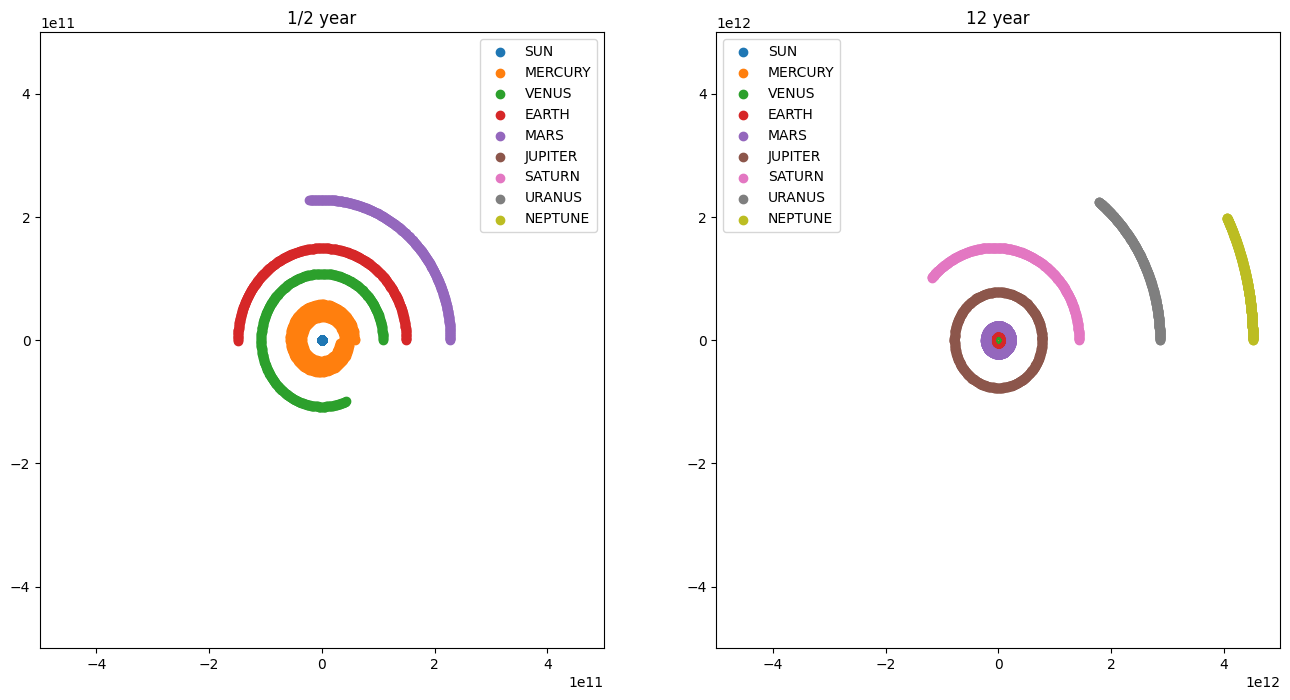

In [180]:
plt.figure(figsize=(16,8))

year = 31_536_000

t1 =  np.linspace(0, 1/2 * year, 365)
result1 = solve_ivp(n_body_system, (0, 1/2 * year), y0, t_eval=t1)
solution1 = result1.y.T

sb1 = plt.subplot(1,2,1)
scat_plots_1 = []
for i in range(0, solution1.shape[1], 4):
    scat_plots_1.append(sb1.scatter(solution1[:, i], solution1[:, i+1], label=names[i//4]))
sb1.set_title('1/2 year')

ax = plt.gca()
ax.set_xlim([-5e+11, 5e+11])
ax.set_ylim([-5e+11, 5e+11])

t2 =  np.linspace(0, 12* year, 365)
result2 = solve_ivp(n_body_system, (0, 12 * year), y0, t_eval=t2, method='Radau')
solution2 = result2.y.T

sb2 = plt.subplot(1,2,2)
scat_plots_2 = []
for i in range(0, solution2.shape[1], 4):
    scat_plots_2.append(sb2.scatter(solution2[:, i], solution2[:, i+1], label=names[i//4]))
sb2.set_title('12 year')
ax = plt.gca()
ax.set_xlim([-5e+12, 5e+12])
ax.set_ylim([-5e+12, 5e+12])

sb1.legend()
sb2.legend()
plt.show()

### П.2. Метод Верле

In [101]:
def a(y):
    '''
    a[0] ~ a_x
    a[1] ~ a_y
    '''
    a = np.zeros((y.shape[0]//4, 2), dtype=np.float64)
    
    for i in range(0, y.shape[0], 4): 
        for j in range(0, y.shape[0], 4): 
            if (i == j): continue
            x_length = y[j] - y[i]
            y_length = y[j+1] - y[i+1]
            r2 = x_length**2 + y_length**2
            r = np.sqrt(r2)
            f = G * m[j // 4] / r2
            a[i//4, 0] += f * x_length / r
            a[i//4, 1] += f * y_length / r
    return a


def verlet(t, y0):
    '''
    y[i] ~ x[i]
    y[i+1] ~ y[i]
    y[i+2] ~ v_x[i]
    y[i+3] ~ v_y[i]
    '''
    
    dt = t.astype(np.float64)[1]
    
    solution = np.empty((t.shape[0], y0.shape[0]), dtype=np.float64)
    
    solution[0, :] = y0
    a_n = a(solution[0, :])
    
    for i in range(1, solution.shape[0]):
        solution[i, 0:4] = solution[i-1, 0:4]
        
        for j in range(4, solution.shape[1], 4): 
            index = j//4
            solution[i, j] = solution[i-1, j] + solution[i-1, j+2] * dt + 0.5 * a_n[index, 0] * dt**2
            solution[i, j+1] = solution[i-1, j+1] + solution[i-1, j+3] * dt + 0.5 * a_n[index, 1] * dt**2
        
        a_n1 = a(solution[i, :])
        
        for j in range(4, solution.shape[1], 4): 
            index = j//4
            solution[i, j+2] = solution[i-1, j+2] + 0.5 * (a_n1[index, 0] + a_n[index, 0]) * dt
            solution[i, j+3] = solution[i-1, j+3] + 0.5 * (a_n1[index, 1] + a_n[index, 1]) * dt
        
        a_n = a_n1
    
    return solution

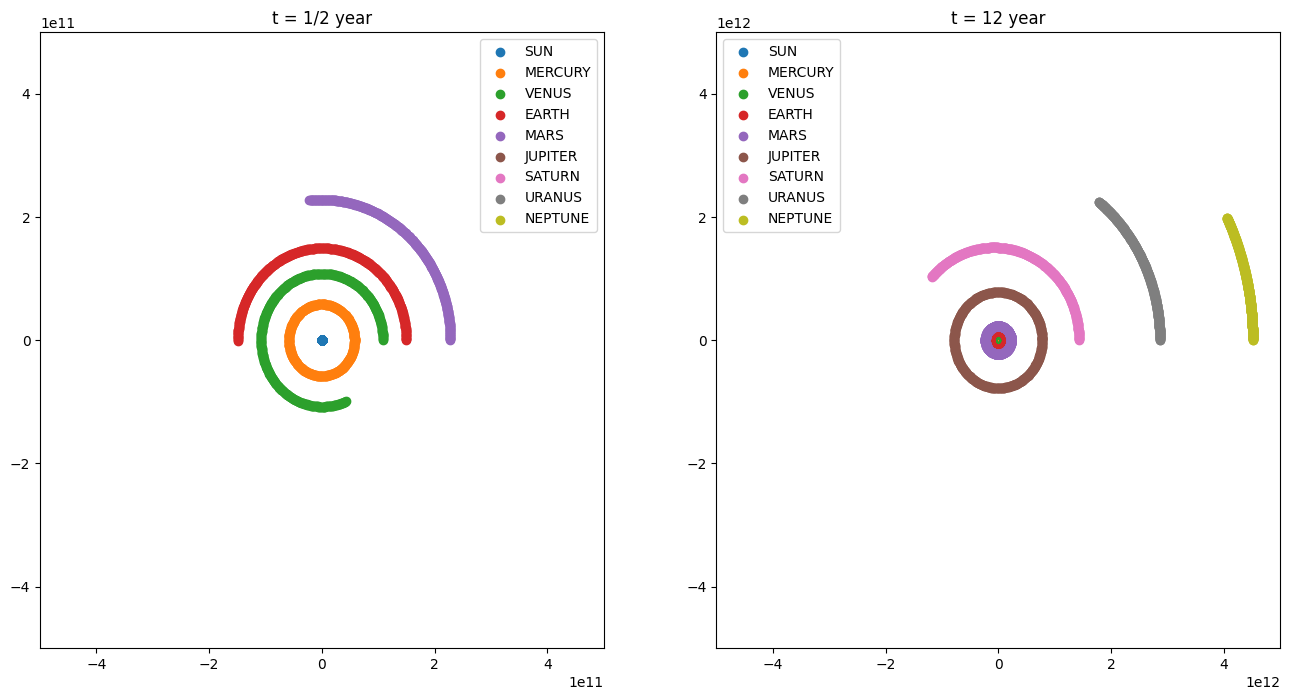

In [161]:
plt.figure(figsize=(16,8))

year = 31_536_000

t1 =  np.linspace(0, 1/2 * year, 365)
solution1 = verlet(t1, y0)

sb1 = plt.subplot(1,2,1)
scat_plots_1 = []
for i in range(0, solution1.shape[1], 4):
    scat_plots_1.append(sb1.scatter(solution1[:, i], solution1[:, i+1], label=names[i//4]))
sb1.set_title('t = 1/2 year')

ax = plt.gca()
ax.set_xlim([-5e+11, 5e+11])
ax.set_ylim([-5e+11, 5e+11])

t2 =  np.linspace(0, 12 * year, 365)
solution2 = verlet(t2, y0)
    
sb2 = plt.subplot(1,2,2)
scat_plots_2 = []
for i in range(0, solution2.shape[1], 4):
    scat_plots_2.append(sb2.scatter(solution2[:, i], solution2[:, i+1], label=names[i//4]))
sb2.set_title('t = 12 year')
ax = plt.gca()
ax.set_xlim([-5e+12, 5e+12])
ax.set_ylim([-5e+12, 5e+12])

sb1.legend()
sb2.legend()
plt.show()